In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn as nn
from torch.autograd import Variable
import sys
import torch.nn.functional as F
from torch.nn import init
sys.path.append("..")
import d2lzh_pytorch as d2l
DOWNLOAD_MNIST = True

In [4]:
BATCH_SIZE = 256
train_data = torchvision.datasets.FashionMNIST(
    root='./FashionMNIST',
    download=DOWNLOAD_MNIST,
    train=True,
    transform=transforms.ToTensor()
)

test_data = torchvision.datasets.FashionMNIST(
    root='./FashionMNIST',
    train=False,
    download=DOWNLOAD_MNIST,
    transform=transforms.ToTensor()
)

train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
test_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

In [5]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(28*28, 10) #如果不加dim的话会警告
            #即对于softmax的隐式维度选择已经被弃用。更改调用包含dim = X作为参数。
        )

    def forward(self, x):
        output = self.linear(x.view(x.shape[0], -1))
        return output

net = LinearNet()

In [6]:
init.normal_(net.linear[0].weight, mean=0, std=0.01)
init.constant_(net.linear[0].bias, val=0)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)

In [7]:
BATCH_SIZE = 256
EPOCH = 5

def evaluate_accuracy():
    acc_test, sum_test = 0., 0
    for x, y in test_loader:
        x = Variable(x)
        out = net(x)
        out = F.softmax(out, dim=1)
        acc_test += (out.argmax(dim=1) == y).float().sum().item()
        sum_test += y.shape[0]

    return acc_test, sum_test

for epoch in range(EPOCH):
    loss_train, acc_train, sum_train = 0., 0., 0
    for step, (batch_x, batch_y) in enumerate(train_loader):
        b_x = Variable(batch_x)
        out = net(b_x)
        loss = loss_func(out, batch_y)
        #优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        out = F.softmax(out, dim=1)
        #计算准确率
        acc_train += (out.argmax(dim=1) == batch_y).float().sum().item()
        sum_train += batch_y.shape[0]
        loss_train += loss.item()

    acc_test, sum_test = evaluate_accuracy()

    print('epoch:', epoch, 
          '|train_loss: %.4f' % (loss_train / sum_train),
          '| train_acc: %.4f' % (acc_train / sum_train), 
          '|test_acc: %.4f' % (acc_test / sum_test))


epoch: 0 |train_loss: 0.0031 | train_acc: 0.7477 |test_acc: 0.8051
epoch: 1 |train_loss: 0.0022 | train_acc: 0.8139 |test_acc: 0.8230
epoch: 2 |train_loss: 0.0021 | train_acc: 0.8259 |test_acc: 0.8228
epoch: 3 |train_loss: 0.0020 | train_acc: 0.8319 |test_acc: 0.8292
epoch: 4 |train_loss: 0.0019 | train_acc: 0.8368 |test_acc: 0.8375


In [8]:
#将数值标签转换为文本标签
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

#可以在一行里画出多张图的函数
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()


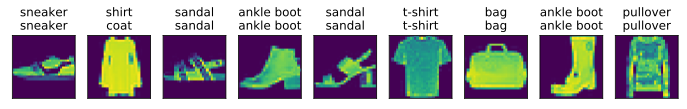

In [9]:
X, y = iter(test_loader).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
temp = F.softmax(net(Variable(X)), dim=1).argmax(dim=1)
pred_labels = d2l.get_fashion_mnist_labels(temp.numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
show_fashion_mnist(X[10:19], titles[10:19])
# d2l.show_fashion_mnist(X[0:9], titles[0:9])
